In [2]:
import sys
print("Versão do python que utilizaremos:",sys.version)

Versão do python que utilizaremos: 3.11.5 | packaged by Anaconda, Inc. | (main, Sep 11 2023, 13:26:23) [MSC v.1916 64 bit (AMD64)]


In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin as pg
import statsmodels.api as sm
from scipy.stats import boxcox
from scipy import stats
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
import joblib

In [6]:
dados = pd.read_excel("C:\\Users\\Usuário\\Exercícios Supervised ML Adicionais\\preço_casas.xlsx")
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545 entries, 0 to 544
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   preco             545 non-null    int64 
 1   area_sqm          545 non-null    int64 
 2   quartos           545 non-null    int64 
 3   banheiros         545 non-null    int64 
 4   rua_principal     545 non-null    object
 5   quarto_hospedes   545 non-null    object
 6   porao             545 non-null    object
 7   aquecimento_agua  545 non-null    object
 8   ar_condicionado   545 non-null    object
 9   vagas_garagem     545 non-null    int64 
 10  local_pref        545 non-null    object
 11  mobilia           545 non-null    object
dtypes: int64(5), object(7)
memory usage: 51.2+ KB


In [7]:
dados['rua_principal'].value_counts()
dados['quarto_hospedes'].value_counts()

quarto_hospedes
não    448
sim     97
Name: count, dtype: int64

In [8]:
pg.rcorr(dados[['preco', 'area_sqm', 'quartos', 'banheiros', 'vagas_garagem']], method='pearson')

,preco,area_sqm,quartos,banheiros,vagas_garagem
preco,-,***,***,***,***
area_sqm,0.536,-,***,***,***
quartos,0.366,0.152,-,***,**
banheiros,0.518,0.194,0.374,-,***
vagas_garagem,0.384,0.353,0.139,0.177,-


In [9]:
dados = pd.get_dummies(dados, columns=['rua_principal', 'quarto_hospedes', 'porao', 'aquecimento_agua', 'ar_condicionado', 'local_pref', 'mobilia'], drop_first=True)

In [10]:
dados['preco_bc'], _ = boxcox(dados['preco'])

In [11]:
X = sm.add_constant(dados[['area_sqm', 'quartos', 'banheiros', 'vagas_garagem']])  # Variáveis independentes
y = dados['preco_bc']

In [12]:
modelo = sm.OLS(y, X).fit()
print(modelo.summary())

                            OLS Regression Results                            
Dep. Variable:               preco_bc   R-squared:                       0.484
Model:                            OLS   Adj. R-squared:                  0.480
Method:                 Least Squares   F-statistic:                     126.6
Date:                Fri, 04 Oct 2024   Prob (F-statistic):           3.50e-76
Time:                        08:40:59   Log-Likelihood:                 901.40
No. Observations:                 545   AIC:                            -1793.
Df Residuals:                     540   BIC:                            -1771.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             5.9711      0.009    648.677

In [13]:
def breusch_pagan_test(modelo):
    df = pd.DataFrame({'yhat': modelo.fittedvalues, 'resid': modelo.resid})
    df['up'] = (np.square(df.resid)) / np.sum((np.square(df.resid)) / df.shape[0])
    modelo_aux = sm.OLS.from_formula('up ~ yhat', df).fit()
    chisq = sm.stats.anova_lm(modelo_aux, typ=2)['sum_sq'][0]
    p_value = stats.chi2.pdf(chisq, 1) * 2
    return chisq, p_value

In [14]:
teste_bp = breusch_pagan_test(modelo)
print(f"p-value: {teste_bp[1]}")

p-value: 0.027748436735497303


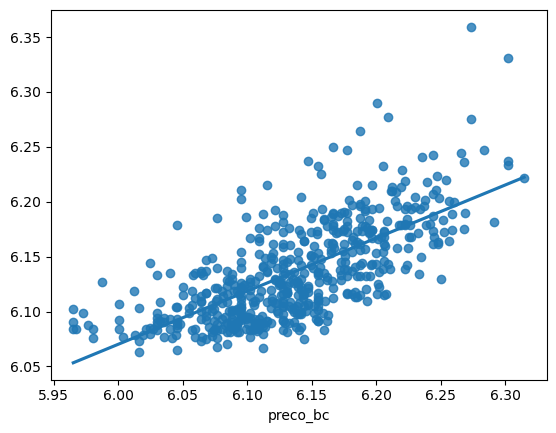

In [16]:
sns.regplot(x=dados['preco_bc'], y=modelo.fittedvalues, ci=None)
plt.show()

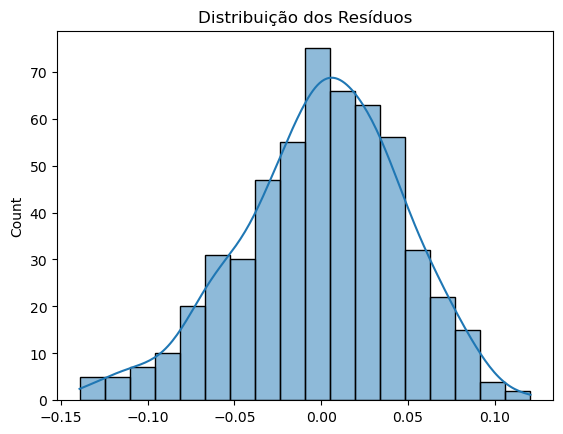

In [17]:
residuos = modelo.resid  # Resíduos do modelo
sns.histplot(residuos, kde=True)
plt.title('Distribuição dos Resíduos')
plt.show()

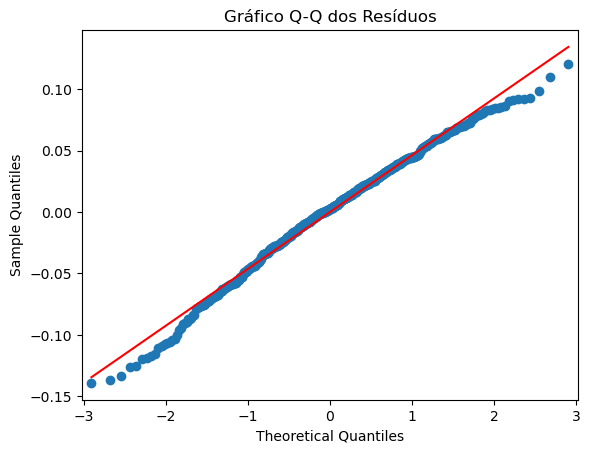

In [18]:
sm.qqplot(residuos, line='s')
plt.title('Gráfico Q-Q dos Resíduos')
plt.show()

In [19]:
modelo_robusto = sm.RLM(y, X).fit()
print(modelo_robusto.summary())

                    Robust linear Model Regression Results                    
Dep. Variable:               preco_bc   No. Observations:                  545
Model:                            RLM   Df Residuals:                      540
Method:                          IRLS   Df Model:                            4
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Fri, 04 Oct 2024                                         
Time:                        09:23:21                                         
No. Iterations:                    33                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             5.9703      0.009    631.552

In [20]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [21]:
vif = pd.DataFrame()
vif['Variável'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif)

        Variável        VIF
0          const  21.355685
1       area_sqm   1.170839
2        quartos   1.174941
3      banheiros   1.199310
4  vagas_garagem   1.162123


In [23]:
X_cross = dados[['area_sqm', 'quartos', 'banheiros', 'vagas_garagem']]  # Sem constante
y_cross = dados['preco_bc']

In [24]:
modelo_cv = LinearRegression()
scores = cross_val_score(modelo_cv, X_cross, y_cross, cv=5, scoring='neg_mean_squared_error')

In [25]:
print(f'Média do MSE: {-np.mean(scores)}')

Média do MSE: 0.0034946258520003174


In [28]:
joblib.dump(modelo, 'modeloMlSupervisionado_preco_casas.pkl')

['modeloMlSupervisionado_preco_casas.pkl']